# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The Traveling Salesman Problem

__Goal:__ Find the shortest tour visiting each of $n$ cities once. Given are pairwise distances between cities. 

__State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  with the order in which the cities are visited (a permutation).

__Objective function:__ Minimize the tour length.

The optimization problem is to find the optimal arrangement $a^*$ of $n$ queens on the board:

$$\mathrm{argmin}_\pi [ \mathrm{tourLength}(\pi) ]$$

$$\text{s.t.}\ \pi \ \text{is a valid permutation vector}$$

__Local moves:__ Exchange two cities in the order.

## Helper functions


In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('precision', 2)

# make the results repeatable
np.random.seed(1234)

In [175]:
def random_tour(n):
    """Create a random tour"""
    
    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[0, 9, 2, 7, 3, 4, 8, 1, 6, 5]

In [176]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a 
    pairwise Euclidean distance matrix.
    """
    
    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })
    
    dist = squareform(pdist(pos))
    
    return({"pos": pos, "dist": dist})
    
tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [177]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""
    
    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()
    
    tl = 0
    dist = tsp["dist"]
    
    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]
    
    tl += dist[tour[-1], tour[0]]
    
    return(tl)
        
tour = random_tour(10)
tour_length(tsp, tour)

4.481464311979203

In [178]:
def show_tsp(tsp, tour = None):  
    """display the traveling salesman problem and a tour."""
    
    pos = tsp["pos"]
    
    plt.scatter(pos["x"], pos["y"])
    
    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()
        
        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")
        
        pos_ = pos.reindex(tour)
        pos_ = pos_.append(pos_.head(1))
        plt.plot(pos_["x"], pos_["y"])
    
    plt.show()
    
show_tsp(tsp, tour)

Tour length: 4.48


## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [179]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

In [180]:
%%R -i d -o tour

library("TSP")

tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 100)
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‘TSP’ 
10 cities (distance ‘unknown’) 
object of class ‘TOUR’ 
result of method ‘arbitrary_insertion+two_opt_rep_100’ for 10 cities
tour length: 2.763574 


Tour length: 2.76


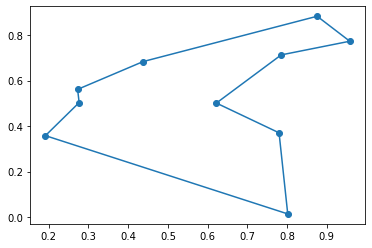

In [181]:
show_tsp(tsp, tour)

How long does it take to solve the problem?

In [182]:
%%R -i d

library("microbenchmark")

microbenchmark(tsp <- TSP(d))

Unit: microseconds
          expr     min      lq     mean   median       uq    max neval
 tsp <- TSP(d) 287.868 300.804 335.3012 324.3715 363.0205 594.16   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

In [183]:
# Code goes here

## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

In [184]:
# Code goes here

## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

In [185]:
# Code goes here

## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

I implement two different local moves. Swapping two cities and reversing the subtour between two cities (which is better).

In [186]:
def move_swap(tour):
    new_tour = tour.copy()
    
    # np.random.randint is inclusive lower limit and exclusive upper limit
    [a, b] = np.random.randint(0, len(tour), 2)
    #print(f"a={a}, b={b}")
    
    new_tour[a] = tour[b]
    new_tour[b] = tour[a]
    return(new_tour)

print(move_swap(list(range(10))))
print(move_swap(list(range(10))))
print(move_swap(list(range(10))))

[7, 1, 2, 3, 4, 5, 6, 0, 8, 9]
[9, 1, 2, 3, 4, 5, 6, 7, 8, 0]
[0, 1, 3, 2, 4, 5, 6, 7, 8, 9]


In [187]:
def move_swap_neighbors(tour):
    new_tour = tour.copy()
    
    a = np.random.randint(0, len(tour)-1, 1)[0]
    if a > 0: b = a+1
    else: b = len(tour)-1  
    #print(f"a={a}, b={b}")
    
    new_tour[a] = tour[b]
    new_tour[b] = tour[a]
    return(new_tour)

print(move_swap_neighbors(list(range(10))))
print(move_swap_neighbors(list(range(10))))
print(move_swap_neighbors(list(range(10))))

[0, 1, 2, 4, 3, 5, 6, 7, 8, 9]
[0, 2, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 3, 5, 6, 7, 8, 9]


In [188]:
def move_reverse(tour):
    new_tour = tour.copy()
    
    ab = np.random.randint(0, len(tour)+1, 2)
    ab.sort()
    #print(f"a={ab[0]}, b={ab[1]}")
        
    new_tour[ab[0]:ab[1]] = new_tour[ab[0]:ab[1]][::-1]
    return(new_tour)

print(move_reverse(list(range(10))))
print(move_reverse(list(range(10))))
print(move_reverse(list(range(10))))

[0, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0, 1, 2, 6, 5, 4, 3, 7, 8, 9]
[0, 9, 8, 7, 6, 5, 4, 3, 2, 1]


I don't know what the optimal tour is so I run the algorithm for `max_steps` steps, but stop if there is no improvement for `stop_after` steps.

In [189]:
def FCHC(tsp, tour = None, local_move_method = move_swap, 
         max_steps = 1000000, stop_after = 1000, verbose = True):
    
    n = len(tsp['pos'])
    
    # 1. initialize current tour
    # current tour = initial tour (random if no tour is given)
    if not tour is None:
        current_tour = tour
    else:
        current_tour = random_tour(n)
    
    
    # initial tour length
    current_length = tour_length(tsp, current_tour)    
    if verbose: print(f"initial tour length: {current_length}")
    
    # step when we last improved the length
    last_improvement_step = 0
    
    # 2. repeat local moves
    for step in range(max_steps):
        
        new_tour = local_move_method(current_tour)
        new_length = tour_length(tsp, new_tour)
        
        # check if the new tour is better   
        if new_length < current_length: 
            current_tour = new_tour
            current_length = new_length
            last_improvement_step = step
            if verbose: print(f"step: {step} - new tour length: {current_length}")
    
        # stop if we did not improve for stop_after steps
        if step - last_improvement_step > stop_after: 
            if verbose: print(f"step: {step} - no improvement for {stop_after} steps.")
            break
      
    return(current_tour)

In [190]:
initial_tour = random_tour(len(tsp['pos']))
show_tsp(tsp, initial_tour)

Tour length: 5.07


In [191]:
%time tour = FCHC(tsp, initial_tour, local_move_method = move_swap)
show_tsp(tsp, tour)

initial tour length: 5.074808011656379
step: 0 - new tour length: 4.955035085581407
step: 1 - new tour length: 4.352111570060356
step: 5 - new tour length: 4.035079731795928
step: 9 - new tour length: 3.8594372397506054
step: 12 - new tour length: 3.41122131956838
step: 21 - new tour length: 3.2403716435166237
step: 52 - new tour length: 3.153223959037089
step: 65 - new tour length: 3.047219924886294
step: 91 - new tour length: 3.0009047090223695
step: 107 - new tour length: 2.9062078251965873
step: 1108 - no improvement for 1000 steps.
CPU times: user 46.9 ms, sys: 372 µs, total: 47.3 ms
Wall time: 40.2 ms
Tour length: 2.91


initial tour length: 5.074808011656379
step: 1 - new tour length: 4.333016916313861
step: 16 - new tour length: 4.150141271100165
step: 1017 - no improvement for 1000 steps.
CPU times: user 46.4 ms, sys: 12.1 ms, total: 58.5 ms
Wall time: 51.5 ms
Tour length: 4.15


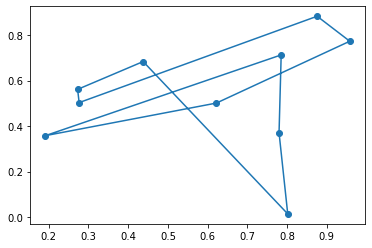

In [192]:
%time tour = FCHC(tsp, initial_tour, local_move_method = move_swap_neighbors)
show_tsp(tsp, tour)

initial tour length: 5.074808011656379
step: 0 - new tour length: 4.670214473900359
step: 3 - new tour length: 4.4645016706205425
step: 6 - new tour length: 4.077715454767877
step: 13 - new tour length: 4.030431740527397
step: 14 - new tour length: 4.017787203943739
step: 23 - new tour length: 3.7054502461733234
step: 24 - new tour length: 3.6934242770113843
step: 29 - new tour length: 3.404936205932136
step: 32 - new tour length: 3.3940061285135688
step: 37 - new tour length: 3.388418407908896
step: 50 - new tour length: 3.0396707255400464
step: 79 - new tour length: 2.9525230410605117
step: 104 - new tour length: 2.8810894251962416
step: 1105 - no improvement for 1000 steps.
CPU times: user 54.6 ms, sys: 0 ns, total: 54.6 ms
Wall time: 52.4 ms
Tour length: 2.88


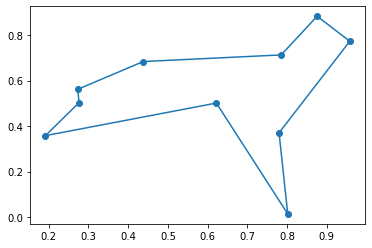

In [193]:
%time tour = FCHC(tsp, initial_tour, local_move_method = move_reverse)
show_tsp(tsp, tour)

Compare the two types of local moves

In [194]:
N = 100 # replications
n = 20 # number of cities

results = { 
    'swap' : np.zeros(shape = [N]),
    'swap_neighbors' : np.zeros(shape = [N]),
    'reverse' : np.zeros(shape = [N]) 
}

for i in range(N):
    tsp_test = random_tsp(n)
    initial_tour = random_tour(n)
    
    results['swap'][i] = tour_length(tsp_test, 
        FCHC(tsp_test, initial_tour, local_move_method = move_swap, verbose = False))
    
    results['swap_neighbors'][i] = tour_length(tsp_test, 
        FCHC(tsp_test, initial_tour, local_move_method = move_swap_neighbors, verbose = False))
    
    results['reverse'][i] = tour_length(tsp_test, 
        FCHC(tsp_test, initial_tour, local_move_method = move_reverse, verbose = False))

    swap  swap_neighbors  reverse
0   3.51            7.07     3.54
1   5.42            8.61     4.16
2   3.77            6.71     3.77
3   3.98            7.70     3.39
4   4.59            8.21     3.78
..   ...             ...      ...
95  5.28            8.66     4.24
96  4.42            9.33     3.73
97  4.51            7.87     3.93
98  5.18            8.62     4.16
99  4.73            7.51     4.05

[100 rows x 3 columns]
swap              4.62
swap_neighbors    8.25
reverse           3.97
dtype: float64


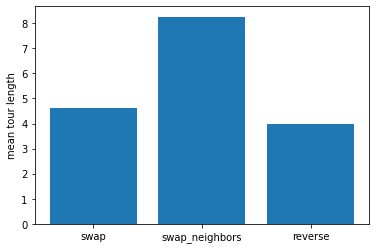

In [195]:
# compare averages
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(results)
print(results)

means = np.mean(results, axis = 0)
print(means)

plt.bar(means.keys(), means)
plt.ylabel("mean tour length")
plt.show()


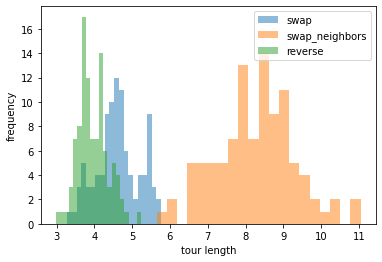

In [196]:
# histogram

plt.hist(results['swap'], bins = 20, alpha = .5)
plt.hist(results['swap_neighbors'], bins = 20, alpha = .5)
plt.hist(results['reverse'], bins = 20, alpha = .5)
plt.xlabel("tour length")
plt.ylabel("frequency")
plt.legend(labels = ["swap", "swap_neighbors", "reverse"])
plt.show()

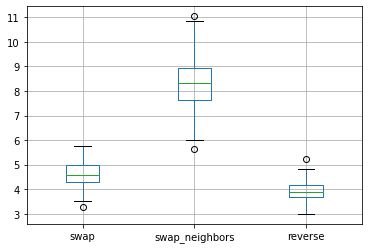

In [197]:
# boxplot (from pandas.DataFrame)

results.boxplot()

In [198]:
# is reverse better than swap?
# perform a paired t-test

from scipy import stats

stats.ttest_rel(results['swap'], results['reverse'])

Ttest_relResult(statistic=14.416189114592555, pvalue=4.6595199039479275e-26)

## Simulated Annealing [2 Points]

In [199]:
def SA(tsp, tour = None, local_move_method = move_reverse, 
         T0 = None, alpha = 0.999, epsilon = 1e-3, verbose = True):
    
    n = len(tsp['pos'])
    
    # 1. initialize current tour
    # current tour = initial tour (random if no tour is given)
    if not tour is None:
        current_tour = tour
    else:
        current_tour = random_tour(n)
    
    # initial tour length
    current_length = tour_length(tsp, current_tour)    
    if verbose: print(f"initial tour length: {current_length:3.3}")
    
    # use the current tour to set T0 (it would be better to sample several ranfom tours instead)
    if T0 is None:
        T0 = current_length
    
    # 2. repeat local moves till temperature is low enough
    T = T0
    t = 0
    while T > epsilon:
        
        # calculate temperature from schedule
        T = T0 * alpha ** t
        
        # create random move
        new_tour = local_move_method(current_tour)
        new_length = tour_length(tsp, new_tour)
        
        deltaE = new_length - current_length
        
        # check if the new tour is better   
        if deltaE < 0 or np.random.rand() < math.exp(-deltaE/T): 
            current_tour = new_tour
            current_length = new_length
            if verbose: print(f"step: {t} \t temp: {T:5.3f} \t deltaE: {deltaE:+3.3f} \t new tour length: {current_length:3.3f}")
      
        t += 1
    
    return(current_tour)

In [200]:
%time tour = SA(tsp, local_move_method = move_swap, verbose = False)
show_tsp(tsp, tour)

CPU times: user 295 ms, sys: 36.4 ms, total: 331 ms
Wall time: 295 ms
Tour length: 2.79


## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [201]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.23794174194335938 milliseconds


In [202]:
# Code and results go here

## Bonus: Genetic Algorithm [+1 Point]

In [203]:
# Code goes here